# **Download Dataset**

In [ ]:
# Install required libraries
!pip install kaggle
!pip install kagglehub

import os
import zipfile
from google.colab import files

# Setup Kaggle credentials
print("Please upload your kaggle.json file...")
uploaded = files.upload()

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset using kagglehub
import kagglehub
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

print("Dataset downloaded to:", path)

# Create a directory for the extracted files
!mkdir -p /content/eye_dataset

# Check if the downloaded path is a zip file or directory
if os.path.isdir(path):
    # If already extracted as a folder, move it directly
    !mv {path}/* /content/eye_dataset/
    print(f"Dataset moved to /content/eye_dataset")
else:
    # If it's a zip file, extract it
    if path.endswith('.zip'):
        with zipfile.ZipFile(path, 'r') as zip_ref:
            zip_ref.extractall('/content/eye_dataset')
            print(f"Extracted: {path}")

print("\nDataset has been downloaded and extracted to /content/eye_dataset")

# Display the contents of the dataset directory
!ls -R /content/eye_dataset

Please upload your kaggle.json file...


Saving kaggle (2).json to kaggle (2).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


100%|██████████| 736M/736M [00:38<00:00, 20.0MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1
Dataset moved to /content/eye_dataset

Dataset has been downloaded and extracted to /content/eye_dataset
/content/eye_dataset:
dataset

/content/eye_dataset/dataset:
cataract  diabetic_retinopathy	glaucoma  normal

/content/eye_dataset/dataset/cataract:
_0_4015166.jpg	  _198_6027510.jpg  2209_left.jpg     _298_9693365.jpg	553_right.jpg
0_left.jpg	  1987_left.jpg     2209_right.jpg    _299_8679417.jpg	_55_8463221.jpg
_100_334408.jpg   _199_2279189.jpg  2210_left.jpg     _300_1946959.jpg	560_left.jpg
_101_5139882.jpg  1994_left.jpg     2210_right.jpg    _301_5387162.jpg	560_right.jpg
_101_709333.jpg   _19_9976222.jpg   2211_left.jpg     _302_3915909.jpg	_56_3359017.jpg
_102_1024926.jpg  _200_9649683.jpg  2211_right.jpg    _302_822867.jpg	_57_3959793.jpg
_102_3990401.jpg  _201_2875079.jpg  2212_left.jpg     _303_1474676.jpg	_57_8463167.jpg
_10_3215668.jpg   _201_841062.jpg   2212_

In [ ]:
!ls /content/eye_dataset/

dataset


# **Import Library**

In [ ]:
# Cell 1: Import libraries and set random seed
import os
import random
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# **Set Configuration**

In [ ]:
# Cell 2: Set Configuration
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 150
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

BASE_PATH = '/content/eye_dataset/dataset'
OUTPUT_PATH = '/content/processed_dataset'

# Define class names
CLASS_NAMES = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

# **Split Data**

In [ ]:
# Cell 3: Create splits and display initial distribution
def check_dataset_structure():
    """Check if all required classes exist in the dataset"""
    missing_classes = []
    for class_name in CLASS_NAMES:
        class_path = os.path.join(BASE_PATH, class_name)
        if not os.path.exists(class_path):
            missing_classes.append(class_name)

    if missing_classes:
        raise Exception(f"Missing classes in dataset: {missing_classes}")

def count_initial_images():
    """Count images in original dataset"""
    counts = {}
    total = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(BASE_PATH, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        counts[class_name] = len(images)
        total += len(images)

    print("\nInitial dataset distribution:")
    print("-" * 40)
    for class_name, count in counts.items():
        percentage = (count/total) * 100
        print(f"{class_name}: {count} images ({percentage:.1f}%)")
    print("-" * 40)
    print(f"Total images: {total}")
    return counts

def create_splits():
    """Create train/validation/test splits"""
    check_dataset_structure()

    # Create output directories
    train_dir = os.path.join(OUTPUT_PATH, 'train')
    val_dir = os.path.join(OUTPUT_PATH, 'validation')
    test_dir = os.path.join(OUTPUT_PATH, 'test')

    # Clear and recreate directories
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)

    split_counts = {'train': {}, 'val': {}, 'test': {}}

    # Process each class
    for class_name in CLASS_NAMES:
        print(f"\nProcessing class: {class_name}")
        class_dir = os.path.join(BASE_PATH, class_name)

        # Create class directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Get all images
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"Total images found: {len(images)}")

        # Calculate split sizes
        total_images = len(images)
        test_val_size = 1 - TRAIN_RATIO
        test_size = TEST_RATIO / test_val_size  # Adjust test_size for second split

        # First split: training vs. (validation + test)
        train_imgs, temp = train_test_split(
            images,
            train_size=TRAIN_RATIO,
            random_state=42
        )

        # Second split: validation vs. test
        val_imgs, test_imgs = train_test_split(
            temp,
            test_size=test_size,
            random_state=42
        )

        # Copy files and count
        for img_list, target_dir, split_name in [
            (train_imgs, train_dir, 'train'),
            (val_imgs, val_dir, 'val'),
            (test_imgs, test_dir, 'test')
        ]:
            for fname in img_list:
                src = os.path.join(class_dir, fname)
                dst = os.path.join(target_dir, class_name, fname)
                shutil.copy2(src, dst)
            split_counts[split_name][class_name] = len(img_list)
            print(f"Copied {len(img_list)} images to {split_name} set")

        # Verify split ratios
        total_after_split = len(train_imgs) + len(val_imgs) + len(test_imgs)
        print(f"\nSplit verification for {class_name}:")
        print(f"Train ratio: {len(train_imgs)/total_after_split:.3f} (target: {TRAIN_RATIO:.3f})")
        print(f"Validation ratio: {len(val_imgs)/total_after_split:.3f} (target: {VAL_RATIO:.3f})")
        print(f"Test ratio: {len(test_imgs)/total_after_split:.3f} (target: {TEST_RATIO:.3f})")

    # Display split distribution
    print("\nData split distribution:")
    print("-" * 60)
    print(f"{'Class':<20} {'Train':>10} {'Validation':>12} {'Test':>10}")
    print("-" * 60)
    for class_name in CLASS_NAMES:
        train_count = split_counts['train'][class_name]
        val_count = split_counts['val'][class_name]
        test_count = split_counts['test'][class_name]
        print(f"{class_name:<20} {train_count:>10} {val_count:>12} {test_count:>10}")
    print("-" * 60)

    return train_dir, val_dir, test_dir

# Execute the splitting process
print("Starting dataset analysis...")
initial_counts = count_initial_images()
print("\nCreating train/validation/test splits...")
train_dir, val_dir, test_dir = create_splits()

Starting dataset analysis...

Initial dataset distribution:
----------------------------------------
cataract: 1038 images (24.6%)
diabetic_retinopathy: 1098 images (26.0%)
glaucoma: 1007 images (23.9%)
normal: 1074 images (25.5%)
----------------------------------------
Total images: 4217

Creating train/validation/test splits...

Processing class: cataract
Total images found: 1038
Copied 726 images to train set
Copied 156 images to val set
Copied 156 images to test set

Split verification for cataract:
Train ratio: 0.699 (target: 0.700)
Validation ratio: 0.150 (target: 0.150)
Test ratio: 0.150 (target: 0.150)

Processing class: diabetic_retinopathy
Total images found: 1098
Copied 768 images to train set
Copied 165 images to val set
Copied 165 images to test set

Split verification for diabetic_retinopathy:
Train ratio: 0.699 (target: 0.700)
Validation ratio: 0.150 (target: 0.150)
Test ratio: 0.150 (target: 0.150)

Processing class: glaucoma
Total images found: 1007
Copied 704 images 

# **Visualisasi Sample**


Displaying sample images from training set:


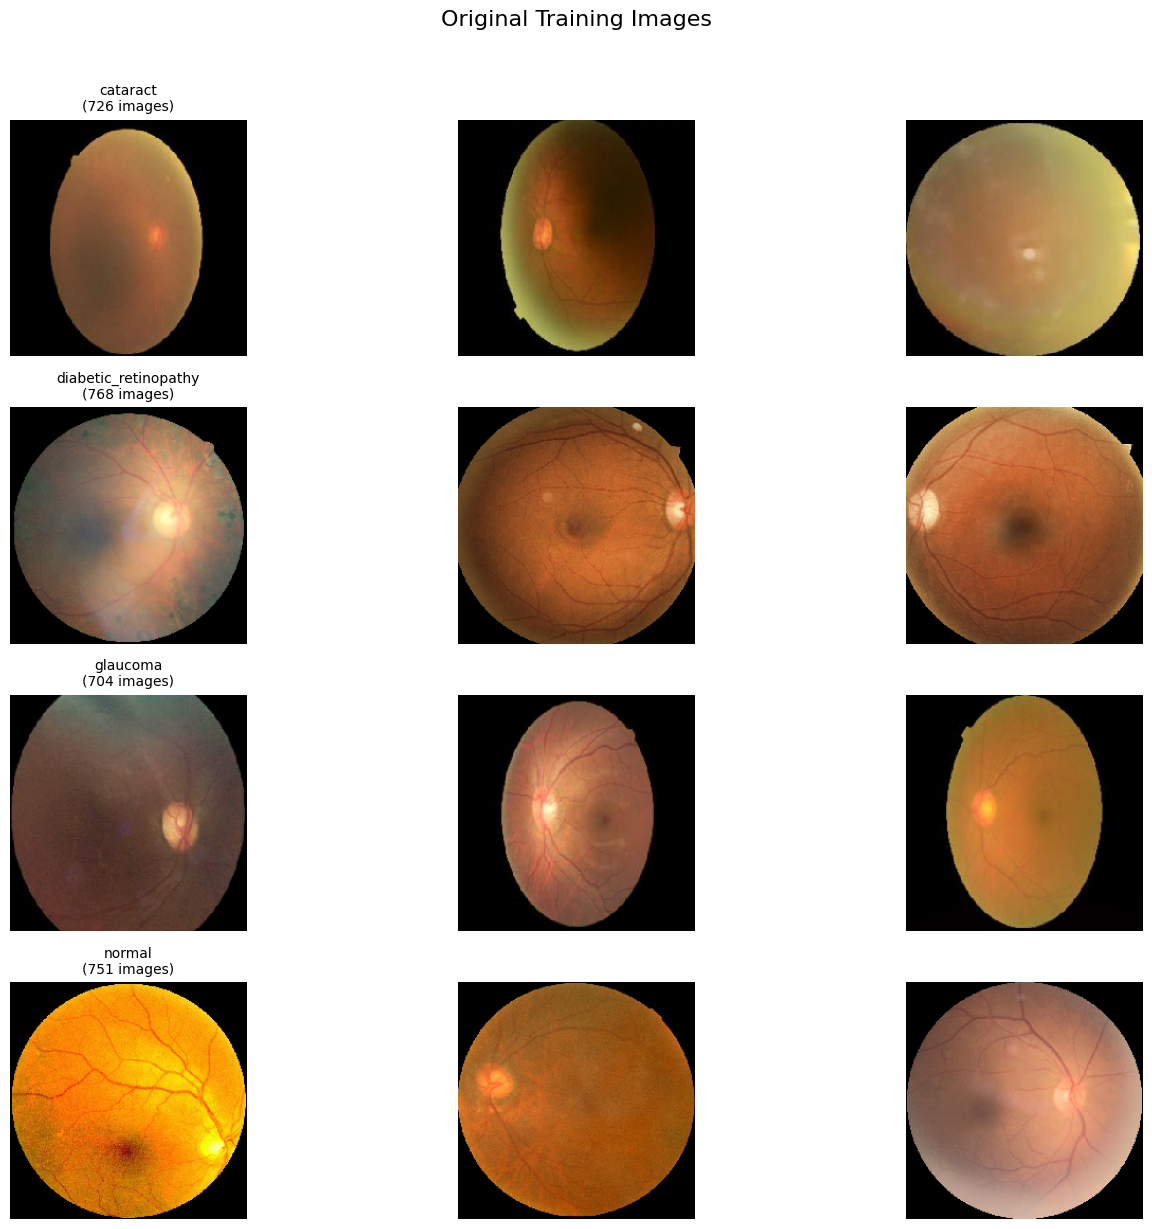

In [ ]:
# Cell 4: Visualize sample images
def plot_sample_images(directory, title, num_samples=3):
    plt.figure(figsize=(15, 12))
    for idx, class_name in enumerate(CLASS_NAMES):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        samples = random.sample(images, min(num_samples, len(images)))

        for i, img_name in enumerate(samples, 1):
            plt.subplot(len(CLASS_NAMES), num_samples, idx*num_samples + i)
            img = load_img(os.path.join(class_path, img_name),
                         target_size=(IMG_SIZE, IMG_SIZE),
                         color_mode='rgb')
            plt.imshow(img)
            plt.axis('off')
            if i == 1:
                plt.title(f"{class_name}\n({len(images)} images)", fontsize=10)

    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

print("\nDisplaying sample images from training set:")
plot_sample_images(train_dir, "Original Training Images")

# **Data Augmentasi**

In [ ]:
# Cell 5: Data Augmentation
def augment_training_data(train_dir, min_total_images=10000):
    """
    Augment training data to achieve a minimum total of 10000 images across all classes,
    while maintaining relative class balance
    """
    print("\nStarting augmentation process...")

    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='constant',
        cval=0,
        brightness_range=[0.9, 1.1]
    )

    augmentation_stats = {
        'original_counts': {},
        'final_counts': {},
        'generated_images': {}
    }

    # First, get original counts
    total_original = 0
    for class_name in CLASS_NAMES:
        class_path = os.path.join(train_dir, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        augmentation_stats['original_counts'][class_name] = len(images)
        total_original += len(images)

    # Calculate multiplication factor needed to reach minimum total
    multiplication_factor = max(min_total_images / total_original, 1)

    # Calculate target count for each class
    target_counts = {
        class_name: int(count * multiplication_factor)
        for class_name, count in augmentation_stats['original_counts'].items()
    }

    print(f"\nTarget counts to reach {min_total_images} total images:")
    for class_name, target in target_counts.items():
        print(f"{class_name}: {target}")

    for class_name in CLASS_NAMES:
        class_path = os.path.join(train_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        original_count = augmentation_stats['original_counts'][class_name]
        target_count = target_counts[class_name]

        print(f"\nProcessing {class_name}")
        print(f"Original count: {original_count}")
        print(f"Target count: {target_count}")

        if original_count >= target_count:
            print(f"Skipping {class_name} as it already has sufficient images")
            augmentation_stats['final_counts'][class_name] = original_count
            augmentation_stats['generated_images'][class_name] = 0
            continue

        num_to_generate = target_count - original_count
        images_processed = 0
        base_images = [os.path.join(class_path, img) for img in os.listdir(class_path)
                      if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

        print(f"Generating {num_to_generate} new images...")

        while images_processed < num_to_generate:
            for img_path in base_images:
                if images_processed >= num_to_generate:
                    break

                img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb')
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)

                batch_count = 0
                for batch in datagen.flow(x,
                                        batch_size=1,
                                        save_to_dir=class_path,
                                        save_prefix=f'aug_{os.path.basename(img_path)[:-4]}',
                                        save_format='jpg'):
                    batch_count += 1
                    images_processed += 1

                    if batch_count >= 1 or images_processed >= num_to_generate:
                        break

                if images_processed % 100 == 0:
                    print(f"Generated {images_processed}/{num_to_generate} images")

        final_count = len([f for f in os.listdir(class_path)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        augmentation_stats['final_counts'][class_name] = final_count
        augmentation_stats['generated_images'][class_name] = final_count - original_count

        print(f"Final count for {class_name}: {final_count}")

    # Display augmentation summary
    print("\nAugmentation Summary:")
    print("-" * 60)
    print(f"{'Class':<20} {'Original':>10} {'Generated':>12} {'Final':>10}")
    print("-" * 60)
    total_original = 0
    total_generated = 0
    total_final = 0
    for class_name in CLASS_NAMES:
        orig = augmentation_stats['original_counts'][class_name]
        gen = augmentation_stats['generated_images'][class_name]
        final = augmentation_stats['final_counts'][class_name]
        total_original += orig
        total_generated += gen
        total_final += final
        print(f"{class_name:<20} {orig:>10} {gen:>12} {final:>10}")
    print("-" * 60)
    print(f"{'Total':<20} {total_original:>10} {total_generated:>12} {total_final:>10}")

    return augmentation_stats

# Call the augmentation function
augmentation_stats = augment_training_data(train_dir, min_total_images=10000)


Starting augmentation process...

Target counts to reach 10000 total images:
cataract: 2461
diabetic_retinopathy: 2604
glaucoma: 2387
normal: 2546

Processing cataract
Original count: 726
Target count: 2461
Generating 1735 new images...
Generated 100/1735 images
Generated 200/1735 images
Generated 300/1735 images
Generated 400/1735 images
Generated 500/1735 images
Generated 600/1735 images
Generated 700/1735 images
Generated 800/1735 images
Generated 900/1735 images
Generated 1000/1735 images
Generated 1100/1735 images
Generated 1200/1735 images
Generated 1300/1735 images
Generated 1400/1735 images
Generated 1500/1735 images
Generated 1600/1735 images
Generated 1700/1735 images
Final count for cataract: 2461

Processing diabetic_retinopathy
Original count: 768
Target count: 2604
Generating 1836 new images...
Generated 100/1836 images
Generated 200/1836 images
Generated 300/1836 images
Generated 400/1836 images
Generated 500/1836 images
Generated 600/1836 images
Generated 700/1836 imag

# **Visualisasi after augmentasi**


Displaying sample images after augmentation:


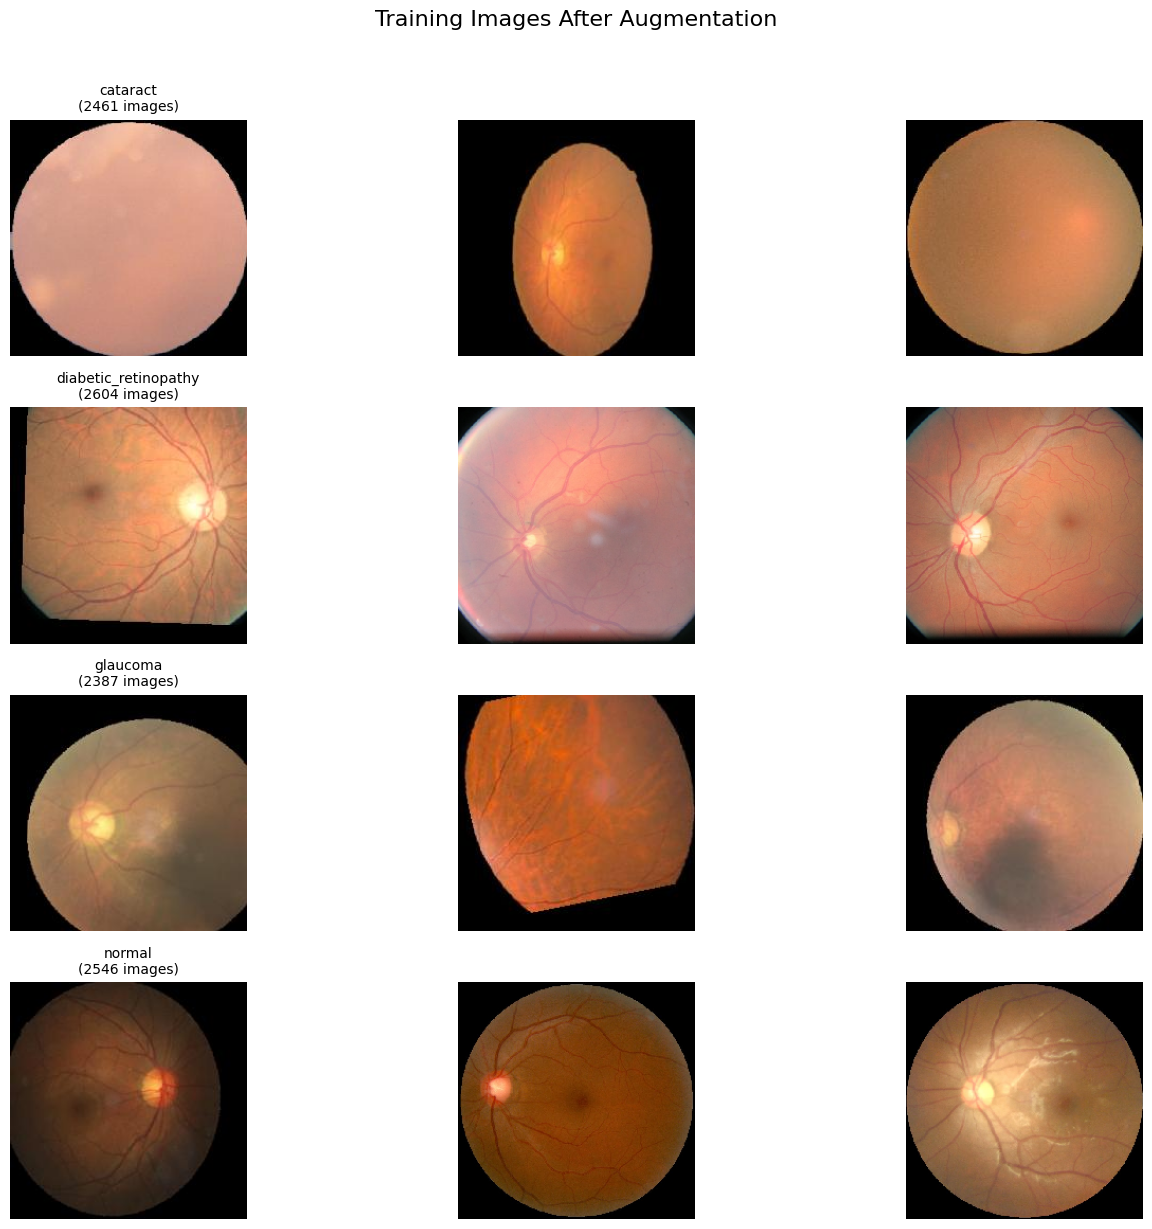

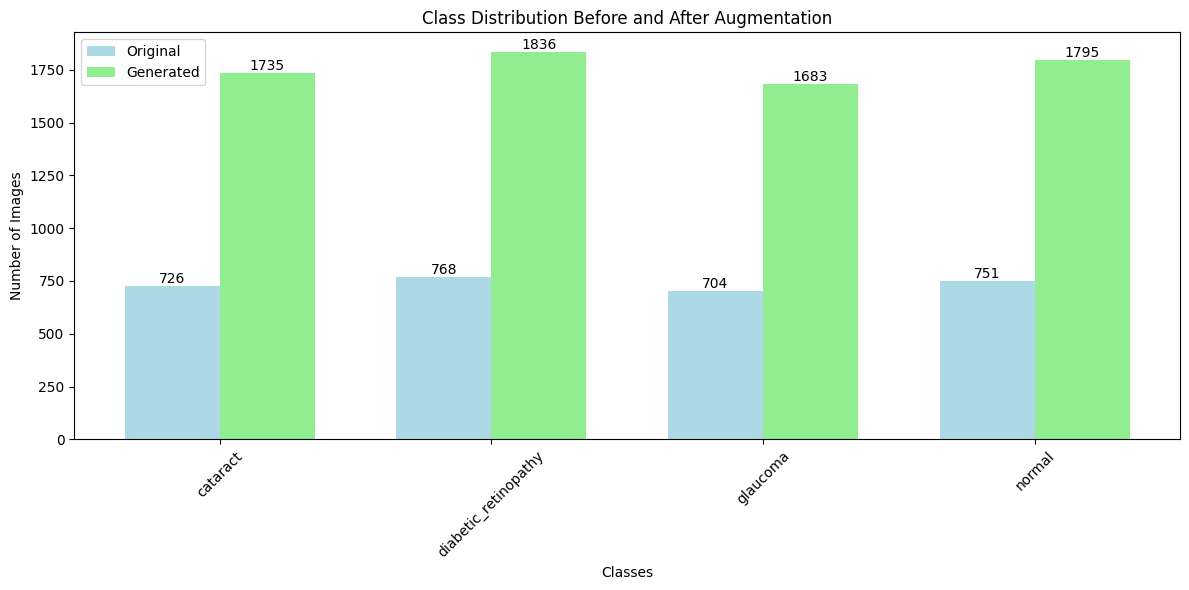

In [ ]:
# Cell 6: Visualize after augmentation
print("\nDisplaying sample images after augmentation:")
plot_sample_images(train_dir, "Training Images After Augmentation")

# Create bar plot of class distribution
plt.figure(figsize=(12, 6))
final_counts = augmentation_stats['final_counts']
classes = list(final_counts.keys())
counts = list(final_counts.values())
original_counts = [augmentation_stats['original_counts'][cls] for cls in classes]
generated_counts = [augmentation_stats['generated_images'][cls] for cls in classes]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, original_counts, width, label='Original', color='lightblue')
plt.bar(x + width/2, generated_counts, width, label='Generated', color='lightgreen')

plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution Before and After Augmentation')
plt.xticks(x, classes, rotation=45)
plt.legend()

for i, v in enumerate(original_counts):
    plt.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(generated_counts):
    plt.text(i + width/2, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


# **Setup Data Generators**

In [ ]:
# Cell 7: Setup Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 9998 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.


# **Compile Model**

In [ ]:
# Cell 8: Build and compile the CNN model
def build_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same',
               input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        # Dense Layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(CLASS_NAMES), activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# **Callbacks**

In [ ]:
# Cell 9: Set up callbacks
def create_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    model_checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    return [early_stopping, reduce_lr, model_checkpoint]


# **Train Model**

In [ ]:
# Cell 10: Train the model
print("Building and training the model...")
model = build_model()

# Print model summary
print("\nModel Summary:")
model.summary()

callbacks = create_callbacks()

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

Building and training the model...

Model Summary:


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_94 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_96               │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_97               │ (None, 28, 28, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 56,205,380 (214.41 MB)

 Trainable params: 56,201,924 (214.39 MB)

 Non-trainable params: 3,456 (13.50 KB)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3317 - loss: 1.8115
Epoch 1: val_accuracy improved from -inf to 0.27138, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 184s 470ms/step - accuracy: 0.3318 - loss: 1.8109 - val_accuracy: 0.2714 - val_loss: 2.0296 - learning_rate: 0.0010
Epoch 2/150
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:04 209ms/step - accuracy: 0.2812 - loss: 1.6121

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.27138
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.2812 - loss: 1.6121 - val_accuracy: 0.2000 - val_loss: 2.2117 - learning_rate: 0.0010
Epoch 3/150
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.4667 - loss: 1.2623
Epoch 3: val_accuracy improved from 0.27138 to 0.58717, saving model to best_model.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 388ms/step - accuracy: 0.4668 - loss: 1.2622 - val_accuracy: 0.5872 - val_loss: 0.9740 - learning_rate: 0.0010
Epoch 4/150
  1/312 ━━━━━━━━━━━━━━━━━━━━ 1:04 208ms/step - accuracy: 0.5000 - loss: 1.0847
Epoch 4: val_accuracy did not improve from 0.58717
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.5000 - loss: 1.0847 - val_accuracy: 0.5600 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 5/150
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5303 - loss: 1.1234
Epoch 5: val_accuracy improved from 0.58717 to 0.62171, saving model to best_model.keras
312/312 ━━━━━━━━━━━━

# **Plot**


Plotting training history...


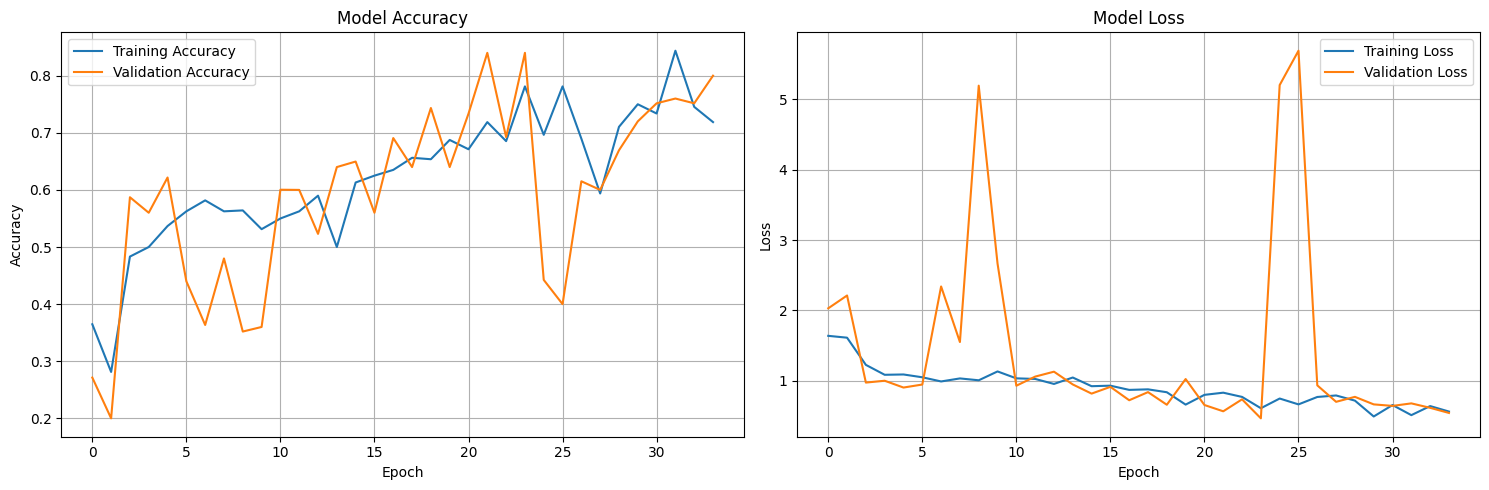

In [ ]:
# Cell 11: Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

print("\nPlotting training history...")
plot_training_history(history)

# **Evaluasi Model**


Evaluating model performance...

Generating predictions for test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 615ms/step

Classification Report:
------------------------------------------------------------
                      precision    recall  f1-score   support

            cataract       0.63      0.92      0.74       156
diabetic_retinopathy       0.96      0.65      0.78       165
            glaucoma       0.60      0.82      0.69       152
              normal       0.72      0.38      0.50       162

            accuracy                           0.69       635
           macro avg       0.73      0.69      0.68       635
        weighted avg       0.73      0.69      0.68       635



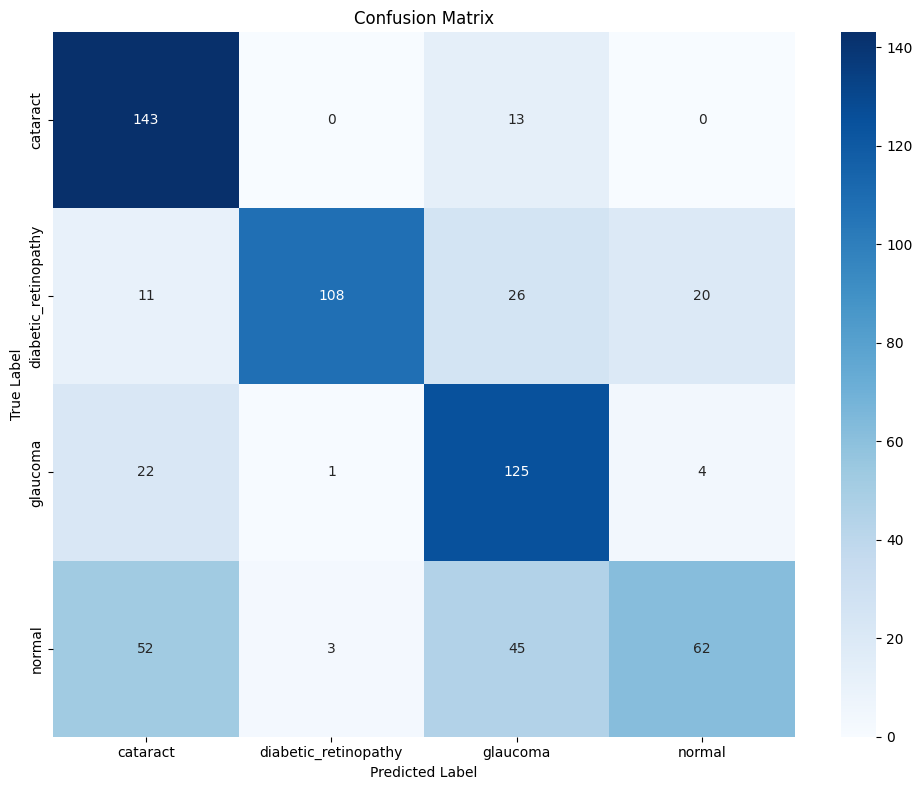

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8082 - loss: 0.5305

Final Test Metrics:
----------------------------------------
Test Accuracy: 0.6898
Test Loss: 0.7845
----------------------------------------


In [ ]:
# Cell 12: Evaluate model and generate classification report
def evaluate_model():
    # Get predictions
    print("\nGenerating predictions for test set...")
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = test_generator.classes

    # Generate and print classification report
    print("\nClassification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES
    )
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Calculate and print test metrics
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("\nFinal Test Metrics:")
    print("-" * 40)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    print("-" * 40)

print("\nEvaluating model performance...")
evaluate_model()

# **Save Model**

In [ ]:
# Cell 14: Save final model and training history
print("\nSaving final model and training history...")

# Save the final model
model.save('/content/drive/MyDrive/UAP ML - eye disease/final_model_cnn.h5')

# Save training history to a file
import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

print("Training complete! Final model and history have been saved.")


Saving final model and training history...
Training complete! Final model and history have been saved.


# **Image Prediksi**


Welcome to Eye Disease Classification System

Eye Disease Classification Menu
1. Start new prediction
2. Exit program

Enter your choice (1 or 2): 1

Options:
1. Upload an image (supported formats: JPG, JPEG, PNG)
2. Skip/Cancel upload
Enter your choice (1 or 2): 1

Please upload your image file...


Saving diabeticretinopathy0916_1045820.jpg to diabeticretinopathy0916_1045820.jpg

Processing image: diabeticretinopathy0916_1045820.jpg


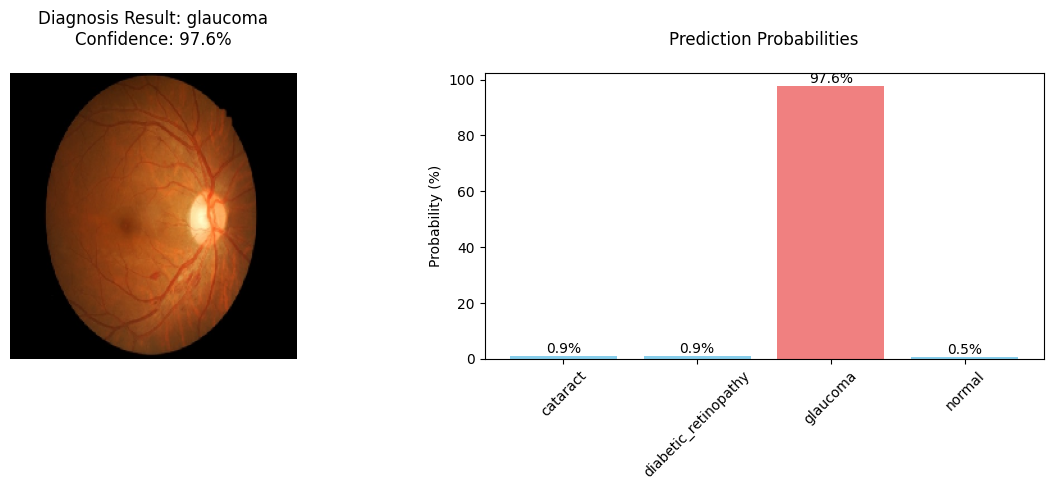


Prediction Results:
--------------------------------------------------
Predicted Class: glaucoma
Confidence: 97.63%

Class Probabilities:
cataract: 0.95%
diabetic_retinopathy: 0.91%
glaucoma: 97.63%
normal: 0.51%
--------------------------------------------------

Eye Disease Classification Menu
1. Start new prediction
2. Exit program

Enter your choice (1 or 2): 2

Exiting program. Goodbye!


In [ ]:
# Model Prediction Code
def predict_image(img_path):
    """
    Make prediction for an uploaded image
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb')
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        predicted_class = CLASS_NAMES[np.argmax(predictions[0])]
        confidence = np.max(predictions[0]) * 100

        # Get probabilities for all classes
        class_probabilities = dict(zip(CLASS_NAMES, predictions[0] * 100))

        # Create figure with two subplots
        plt.figure(figsize=(12, 5))

        # Plot 1: Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Diagnosis Result: {predicted_class}\nConfidence: {confidence:.1f}%',
                 pad=20)
        plt.axis('off')

        # Plot 2: Prediction Probabilities
        plt.subplot(1, 2, 2)
        colors = ['skyblue' if i != np.argmax(predictions[0]) else 'lightcoral'
                 for i in range(len(CLASS_NAMES))]
        bars = plt.bar(CLASS_NAMES, predictions[0] * 100, color=colors)
        plt.title('Prediction Probabilities', pad=20)
        plt.ylabel('Probability (%)')
        plt.xticks(rotation=45)

        # Add percentage labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Print prediction results
        print("\nPrediction Results:")
        print("-" * 50)
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.2f}%")
        print("\nClass Probabilities:")
        for cls, prob in class_probabilities.items():
            print(f"{cls}: {prob:.2f}%")
        print("-" * 50)

    except Exception as e:
        print(f"Error during prediction: {str(e)}")

def handle_upload():
    """
    Handle file upload and make prediction
    """
    while True:
        try:
            print("\nOptions:")
            print("1. Upload an image (supported formats: JPG, JPEG, PNG)")
            print("2. Skip/Cancel upload")
            choice = input("Enter your choice (1 or 2): ").strip()

            if choice == '2':
                print("Upload cancelled. Returning to main menu...")
                return

            elif choice == '1':
                print("\nPlease upload your image file...")
                uploaded = files.upload()

                if uploaded:
                    # Get the filename of the uploaded image
                    filename = next(iter(uploaded))
                    print(f"\nProcessing image: {filename}")

                    # Make prediction
                    predict_image(filename)
                    return

            else:
                print("Invalid choice. Please enter 1 or 2.")

        except Exception as e:
            print(f"Error during upload: {str(e)}")
            return

def main_prediction_loop():
    """
    Main loop for prediction service
    """
    print("\nWelcome to Eye Disease Classification System")
    while True:
        print("\n" + "="*50)
        print("Eye Disease Classification Menu")
        print("="*50)
        print("1. Start new prediction")
        print("2. Exit program")

        choice = input("\nEnter your choice (1 or 2): ").strip()

        if choice == '1':
            handle_upload()
        elif choice == '2':
            print("\nExiting program. Goodbye!")
            break
        else:
            print("Invalid choice. Please enter 1 or 2.")

        time.sleep(0.5)

# Start the prediction service
main_prediction_loop()